## Import packages and declaring functions

In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import shap
import copy
import glob
import re
import pickle
import datetime as dt
from datetime import timezone
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.metrics import get_scorer_names, classification_report, make_scorer,accuracy_score, recall_score
from sklearn.model_selection import cross_val_score, cross_validate ,RepeatedStratifiedKFold, train_test_split

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 


# %history -f notebook_file.ipynb #store history in a file

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 



def kfold_report(model, X,Y):
    print('Computing Different Scores for Kfold=10 ...')
    score_est = {}
    for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
        cvs = cross_val_score(model, X, Y, scoring=score, cv=10).mean().round(3)
        score_est[score] = cvs # Storing like a dictionay 
    print('\n Average Score from cross validation with cv=10 \n', model,':', score_est, '\n')

    originalclass = []   # to store true label for each iteration 
    predictedclass = []  # to store predicted label for each iteration
    # in cross_val_score this function will be called each for each training
    print('Making Classfication report ...')
    def custom_scoring_function(y_true, y_pred):  
        #print(classification_report(y_true, y_pred)) # print classification report for each iteration
        originalclass.extend(y_true) 
        predictedclass.extend(y_pred)
        return recall_score(y_true, y_pred) # return accuracy score , here we can pass f1_score as well with average parameter

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    nested_score = cross_val_score(model, X=X, y=Y, cv=cv, scoring=make_scorer(custom_scoring_function))

    print("Mean Recall from Kfold : %.3f" %np.mean(nested_score))
    print('Over all classification report')
    print(classification_report(originalclass, predictedclass))
    return originalclass, predictedclass


# compute true positive rate and false positive rate

def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# plotting them against each other
    plt.figure(figsize=(8, 3))
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label="plot_roc_curve")
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.show()

# getting the probabilities of our predictions
def plot_precision_recall_curve(y_test, y_pred):
    precision, recall, threshold = precision_recall_curve(y_test, y_pred)
    plt.figure(figsize=(8, 3))
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])
    plt.show()



## Reading Pre processed Data from a csv

In [2]:
data = pd.read_csv('../data/processed/' + '1.1-mu-devlopers-processed-data.csv',index_col=-0)
print(data.shape)
data.head()

(52665, 27)


,source_attribution_type,user_os_type,role_type,english_communication,resume_flag,num_chars_resume_thousands,years_of_experience,years_of_remote_experience,sn_avg_score,num_self_skills,num_self_beginner_skills,num_self_intermediate_skills,num_self_advanced_skills,num_self_expert_skills,is_github,is_linkedIn,time_to_upload_resume,time_to_sn_test,is_quiz_answer_correct,most_exp_skill_name,cluster_label,JavaScript,MySQL,Nodejs,PHP,Vuejs,dev_id
0,Undefined,Mac OS,Mobile,Average,1,2.222,3.0,1.0,3.595834,25.0,20.0,5.0,0.0,0.0,1,1,0.0,0.0,1,Flutter,Low Quality,1.0,0.0,2.0,1.0,2.0,910749
1,Undefined,Linux,Web Backend,Great,1,2.410,6.0,0.0,4.086666,13.0,4.0,1.0,8.0,0.0,0,0,0.0,0.0,1,PHP,Average,0.0,3.0,0.0,3.0,0.0,1294930
2,Undefined,Mac OS,Web Frontend,Great,1,1.693,3.0,1.0,4.456666,14.0,1.0,8.0,3.0,2.0,0,0,0.0,0.0,1,React,Low Experience,1.0,0.0,2.0,0.0,0.0,2368912
3,Facebook,Android OS,Machine Learning,Average,1,2.552,4.0,2.0,3.454166,8.0,3.0,3.0,2.0,0.0,1,1,0.0,5.0,0,SQL,Low Experience,0.0,0.0,0.0,0.0,0.0,2429835
4,Undefined,Undefined,Fullstack (BE-heavy),Average,1,1.807,1.0,1.0,2.955834,13.0,0.0,13.0,0.0,0.0,0,1,0.0,0.0,0,Spring Boot,Low Quality,2.0,2.0,0.0,0.0,0.0,2639530


## Data Prep
- One hot encoding for `role_type`, `user_os_type`, `source_attribution_type`, `english_communication`
- and Defining X & Y dataframes that will be used in ml model

In [4]:
predictors = list(data.columns)
predictors.remove('role_type')
predictors.remove('user_os_type')
predictors.remove('source_attribution_type')
predictors.remove('english_communication')

dev_role = pd.get_dummies(data['role_type'], prefix='role')
dev_os_type = pd.get_dummies(data['user_os_type'], prefix='os_type')
dev_source_attribution = pd.get_dummies(data['source_attribution_type'], prefix='source_attribution')
dev_english = pd.get_dummies(data['english_communication'], prefix='english')

ml_data = data[predictors]
ml_data = pd.concat([ml_data,dev_role],axis=1)
ml_data = pd.concat([ml_data,dev_os_type],axis=1)
ml_data = pd.concat([ml_data,dev_source_attribution],axis=1)
ml_data = pd.concat([ml_data,dev_english],axis=1)

ml_data['label'] = np.where(ml_data['cluster_label'].isin(['Elite', 'High Quality']), 1,0)

X = ml_data.loc[:, ~ml_data.columns.isin(['dev_id', 'cluster_label', 'label'])].copy()
X['most_exp_skill_name']= X['most_exp_skill_name'].astype("category")
Y_label = ml_data['cluster_label']
Y = ml_data['label']
#Y = [1 if val in ['Elite', 'High Quality'] else 0 for val in Y_label]
dev_id = ml_data['dev_id']

df =ml_data.groupby('label').agg({'dev_id':'count'}).reset_index()
df['dev_per'] = round(100*df['dev_id']/sum(df['dev_id']),2)
df = df.sort_values(by='dev_id', ascending=False)
fig = px.bar(df, x='label', y='dev_id',
             hover_data=['dev_id', 'dev_per'], text='dev_per',
             labels={'label':'Is HQ Developer?','dev_id':'Number of Developers'}, height=400)
fig.update_xaxes(type='category')
fig.show()
X.head()

,resume_flag,num_chars_resume_thousands,years_of_experience,years_of_remote_experience,sn_avg_score,num_self_skills,num_self_beginner_skills,num_self_intermediate_skills,num_self_advanced_skills,num_self_expert_skills,is_github,is_linkedIn,time_to_upload_resume,time_to_sn_test,is_quiz_answer_correct,most_exp_skill_name,JavaScript,MySQL,Nodejs,PHP,Vuejs,role_Backend Systems,role_Cloud - AI/ML,role_Cloud - Data,role_Cloud - Networking,role_Cloud - Security,role_Cloud - Solutions Architecture,role_DevOps,role_Full Stack,role_Fullstack (BE-heavy),role_Fullstack (FE-heavy),role_Machine Learning,role_Mobile,role_Other,role_Research,role_Web Backend,role_Web Frontend,os_type_Android OS,os_type_Linux,os_type_Mac OS,os_type_Undefined,os_type_Windows,os_type_iOS,source_attribution_Customer,source_attribution_Facebook,source_attribution_Github,source_attribution_Google,source_attribution_Organic,source_attribution_Outbound,source_attribution_Quora,source_attribution_Remarketing,source_attribution_Undefined,source_attribution_Youtube,source_attribution_ZFD,english_Average,english_Basic,english_Great
0,1,2.222,3.0,1.0,3.595834,25.0,20.0,5.0,0.0,0.0,1,1,0.0,0.0,1,Flutter,1.0,0.0,2.0,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,1,2.410,6.0,0.0,4.086666,13.0,4.0,1.0,8.0,0.0,0,0,0.0,0.0,1,PHP,0.0,3.0,0.0,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,1,1.693,3.0,1.0,4.456666,14.0,1.0,8.0,3.0,2.0,0,0,0.0,0.0,1,React,1.0,0.0,2.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,2.552,4.0,2.0,3.454166,8.0,3.0,3.0,2.0,0.0,1,1,0.0,5.0,0,SQL,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1.807,1.0,1.0,2.955834,13.0,0.0,13.0,0.0,0.0,0,1,0.0,0.0,0,Spring Boot,2.0,2.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


## Correlation and Chi Square test for independenc

In [5]:
from scipy.stats import chi2_contingency


top_skill = list(data.columns[-5:-1])

li = ['user_os_type', 'source_attribution_type', 'is_quiz_answer_correct', 'resume_flag', 'english_communication'\
    , 'role_type','is_github']
li.extend(top_skill)

chi2tests = pd.DataFrame(columns=['feature', 'Fstatistics', 'pvalue'])

ind=0
for i in li:
    con_tab = pd.crosstab(data[i], Y).reset_index()
    con_tab.columns.name = None
    stat, p, dof, expected = chi2_contingency(con_tab.iloc[:, 1:])
    chi2tests.at[ind, 'feature'] = i
    chi2tests.at[ind, 'Fstatistics'] = stat
    chi2tests.at[ind, 'pvalue'] = p
    ind = ind+1


chi2tests.sort_values(by='Fstatistics', ascending=False, inplace=True)
chi2tests['Fstatistics'] = chi2tests['Fstatistics'].astype(int)

import plotly.express as px

fig = px.bar(chi2tests, x="feature", y="Fstatistics", hover_data=['Fstatistics', 'pvalue'], text='Fstatistics', title='Fstatistics and pvalue for categorical features.')
fig.update_traces(textfont_size=12, textangle=0, textposition="inside", cliponaxis=False)
fig.show()

chi2tests.reset_index(drop=True)

,feature,Fstatistics,pvalue
0,role_type,1889,0.0
1,Nodejs,1655,0.0
2,PHP,1443,0.0
3,Vuejs,1257,0.0
4,MySQL,1256,0.0
5,is_github,696,0.0
6,source_attribution_type,383,0.0
7,english_communication,201,0.0
8,resume_flag,142,0.0
9,user_os_type,104,0.0


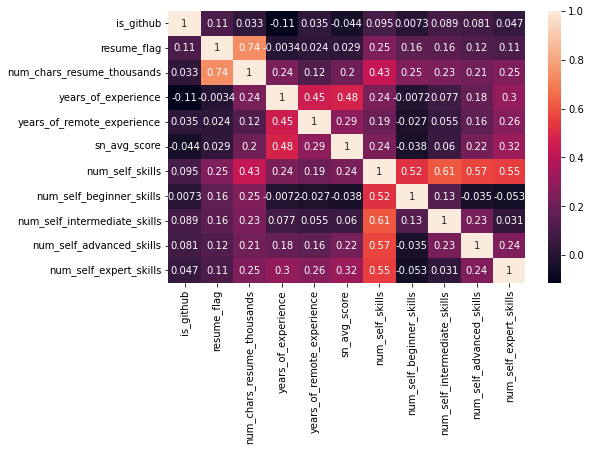

In [6]:

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = data[['is_github','resume_flag', 'num_chars_resume_thousands', 'years_of_experience',\
    'years_of_remote_experience', 'sn_avg_score', 'num_self_skills', 'num_self_beginner_skills',\
        'num_self_intermediate_skills','num_self_advanced_skills','num_self_expert_skills']].corr()
plt.figure(figsize=(8, 5))
sn.heatmap(corrMatrix, annot=True)
plt.show()


## Light Gradient Boosting Model

X_train: (36865, 57) 
y_train: (36865,) 
X_test: (15800, 57) 
y_test: (15800,)
Postive class in train data is 22.9% & Postive class in test data is 22.8%
Testing accuracy
              precision    recall  f1-score   support

           0       0.88      0.69      0.77     12199
           1       0.39      0.69      0.50      3601

    accuracy                           0.69     15800
   macro avg       0.64      0.69      0.64     15800
weighted avg       0.77      0.69      0.71     15800



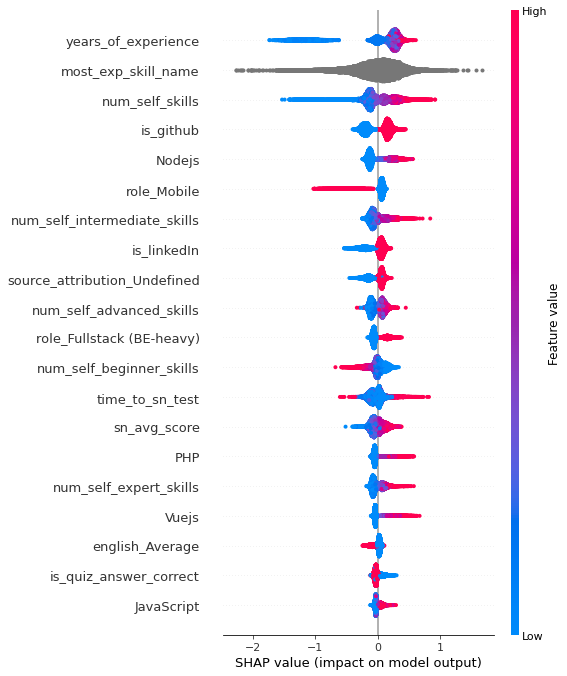

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} \nX_test: {X_test.shape} \ny_test: {y_test.shape}")
print(f"Postive class in train data is {round(100*sum(y_train)/len(y_train),1)}% & Postive class in test data is {round(100*sum(y_test)/len(y_test),1)}%")

from lightgbm import LGBMClassifier

lgb = LGBMClassifier(is_unbalance=True, objective='binary', max_depth=8, min_split_gain = 0.01)
lgb.fit(X_train, y_train)
print('Testing accuracy')
print(classification_report(y_test, lgb.predict(X_test)))
#print('Traing accuracy')
#print(classification_report(y_train, model.predict(X_train)))

lgbm_shap = lgb.predict(X_test, pred_contrib=True)
shap.summary_plot(lgbm_shap[:,:-1], X_test)



Computing Different Scores for Kfold=10 ...

 Average Score from cross validation with cv=10 
 LGBMClassifier(is_unbalance=True, max_depth=8, min_split_gain=0.01,
               objective='binary') : {'roc_auc': 0.75, 'f1': 0.496, 'precision': 0.392, 'recall': 0.687, 'accuracy': 0.68} 

Making Classfication report ...
Mean Recall from Kfold : 0.684
Over all classification report
              precision    recall  f1-score   support

           0       0.88      0.68      0.77     81214
           1       0.39      0.68      0.50     24116

    accuracy                           0.68    105330
   macro avg       0.63      0.68      0.63    105330
weighted avg       0.77      0.68      0.71    105330



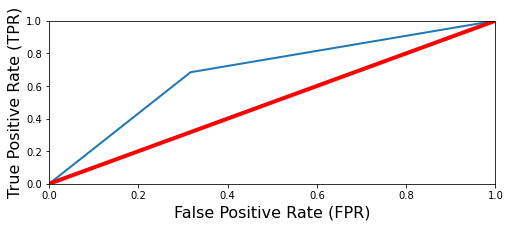

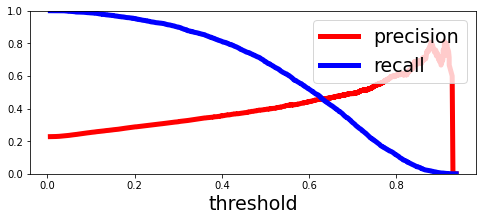

In [9]:
lgb = LGBMClassifier(is_unbalance=True, objective='binary', max_depth=8, min_split_gain = 0.01)

y_test_k, y_pred_k = kfold_report(lgb,X,Y)

# plot roc curve from k fold reults 
plot_roc_curve(y_test=y_test_k, y_pred=y_pred_k)

# plot roc curve from single fit 
lgb.fit(X_train, y_train)
y_pred = lgb.predict_proba(X_test)
y_pred = y_pred[:,1]
plot_precision_recall_curve(y_test, y_pred)

## Hyper parameter Tuining

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# define model
lgb_model = LGBMClassifier(is_unbalance=True, objective='binary')
# define grid
param_grid = dict(max_depth=range(2,12,2), min_split_gain=[val/100 for val in list(range(0,10,2))])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
# define grid search
grid = GridSearchCV(estimator=lgb_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X, Y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))

lgb_model = LGBMClassifier(is_unbalance=True, objective='binary', max_depth=grid_result.best_params_['max_depth'],
min_split_gain = grid_result.best_params_['min_split_gain'])

originalclass = []   # to store true label for each iteration 
predictedclass = []  # to store predicted label for each iteration
def custom_scoring_function(y_true, y_pred):  
    #print(classification_report(y_true, y_pred)) # print classification report for each iteration
    originalclass.extend(y_true) 
    predictedclass.extend(y_pred)
    return recall_score(y_true, y_pred) # return accuracy score , here we can pass f1_score as well with average parameter


nested_score = cross_val_score(lgb_model, X=X, y=Y, cv=10,scoring=make_scorer(custom_scoring_function))

print("Mean Accuracy from Kfold : %.3f" % np.mean(nested_score))
print('\n Over all classification report')
print(classification_report(originalclass, predictedclass)) 



## CatBoostClassifier

In [ ]:
from catboost import CatBoostClassifier, Pool

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} \nX_test: {X_test.shape} \ny_test: {y_test.shape}")
print(f"Postive class in train data is {round(100*sum(y_train)/len(y_train),1)}% & Postive class in test data is {round(100*sum(y_test)/len(y_test),1)}%")

## CatBoostClassifier
catboot = CatBoostClassifier(verbose=False, class_weights={0:1, 1:4})
catboot.fit(X_train, y_train)
print('Testing accuracy')
print(classification_report(y_test, catboot.predict(X_test)))
#print('Traing accuracy')
#print(classification_report(y_train, catboot.predict(X_train)))

shap_values = catboot.get_feature_importance(Pool(X_test, label=y_test) ,type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X_test)


In [ ]:
y_test_k, y_pred_k = kfold_report(catboot,X,Y)

# plot roc curve from k fold reults 
plot_roc_curve(y_test=y_test_k, y_pred=y_pred_k)

# plot roc curve from single fit 
y_pred = catboot.predict_proba(X_test)
y_pred = y_pred[:,1]
plot_precision_recall_curve(y_test, y_pred)
